# The California Racial Justice Act & San Diego PD RIPA Data
Sreetama Chowdhury

## Abstract 

Approved in 2020, the California Racial Justice Act allows defendants to appeal for a retrial of their case or an adjustment of the charges or sentencing leveled at them if they can statistically prove that there was racial bias at play. The bill doesn’t actually specify the kind of statistical proof a judge would require, though, so this project is a preliminary search to start to find out what kinds of aspects of criminal justice data might be useful to those invoking the CRJA. To that end, this project used pandas to analyze a dataset of San Diego city traffic stop data collected under RIPA, the Racial and Identity Profiling Act of 2015. It involved preliminary demographic analysis of various aspects of the stop data, outcome testing in the form of variations of the Veil of Darkness test, and a brief investigation into the phenomenon of multiple charges being pressed after the same stop. Analysis showed, however, that there is as of yet no statistically significant evidence of racial bias being involved as a factor of these stops.

## Table of Contents

1. ### [Introduction](#introduction)
2. ### [Methods](#methods)
3. ### [Results](#results)
4. ### [Discussion](#discussion)
5. ### [Sources + Adjacent Data](#sources)

## Introduction <a id='introduction'></a>

The California Racial Justice Act (AB-2542), approved by the governor in September 2020, is legislation that intends to combat racial bias and disparities in the criminal justice system by offering defendants a chance to contest their cases. The CRJA is usable on multiple levels — checking racial bias both in and out of courtrooms — as it addresses within-court instances of bias as well as racially charged disparities in sentencing, charges, and convictions. If the defendant invoking the CRJA can provide proof of discrimination occurring, a new trial will be set up for the case or the charges or sentence may be adjusted, depending on how far along the court case is. 

It’s key legislation in that it not only takes into account intentional bias directed at the defendant (by any other key figure in the courtroom processes) but also racially coded language or interactions. The aspect of the CRJA that this project specifically has focused on is racial disparities in charges. The evidence needed for proof of discrimination in court (when it comes to racial bias in charges) is differences due to race, national origin, or ethnicity in charges on a county-wide basis. 

The goal of this project was originally to synthesize a database of information (via extensive data collection, organization, and cleaning) that searches for evidence of racial discrimination, bias, or disparities in terms of individuals stopped by the police and what charges they faced as a result. It ended up focusing on a relatively narrow dataset, using pandas to explore and analyze specifically traffic stop data collected by the San Diego Police Department as part of the Racial and Identity Profiling Act of 2015. 


## Methods <a id='methods'></a>

The actual code used to break down & perform various tests — including outcome testing (in the form of several Veil of Darkness tests) and analysis of stacked charges  — on the RIPA stop data.

All data used can be found & downloaded [here](https://data.sandiego.gov/datasets/police-ripa-stops/) and on linked pages.

In [1]:
#import + consolidate San Diego RIPA data into one massive df (result_df)

In [2]:
import pandas as pd   
import missingno as msno
import matplotlib.pyplot as plt
from astral import LocationInfo
from astral.geocoder import database, lookup
import seaborn as sns
import datetime
from datetime import date
from astral.sun import sun
city = lookup("San Diego", database())

def convert_dtype_float(x):
    if not x:
        return 0
    try:
        return float(x)   
    except:        
        return 0
    
def convert_dtype_string(x):
    if not x:
        return ''
    try:
        return str(x)   
    except:        
        return ''
    
convert_dict = {'date_stop': str}
    
contraband_evid_df = pd.read_csv("../data/ripa_contraband_evid_datasd.csv")                                
disability_df = pd.read_csv("../data/ripa_disability_datasd.csv")
gender_df = pd.read_csv("../data/ripa_gender_datasd.csv", converters = {"gender": convert_dtype_string})
prop_seize_basis_df = pd.read_csv("../data/ripa_prop_seize_basis_datasd.csv", converters = {"basisforpropertyseizure": convert_dtype_string})
prop_seize_type_df = pd.read_csv("../data/ripa_prop_seize_type_datasd.csv", converters = {"type_of_property_seized": convert_dtype_string})
race_df = pd.read_csv("../data/ripa_race_datasd.csv")
stop_result_df = pd.read_csv("../data/ripa_stop_result_datasd.csv")
stop_reason_df = pd.read_csv("../data/ripa_stop_reason_datasd.csv", converters = {"reason_for_stopcode": convert_dtype_float})
stop_details_df = pd.read_csv("../data/ripa_stops_datasd.csv", converters = {"land_mark": convert_dtype_string}) 
stop_details_df = stop_details_df.astype(convert_dict)
result_df = pd.merge(contraband_evid_df, disability_df, how="outer", on=["stop_id","pid"])
result_df = pd.merge(result_df, gender_df, how="outer", on=["stop_id","pid"])
result_df = pd.merge(result_df, prop_seize_basis_df, how="outer", on=["stop_id","pid"])
result_df = pd.merge(result_df, prop_seize_type_df, how="outer", on=["stop_id","pid"])
result_df = pd.merge(result_df, race_df, how="outer", on=["stop_id","pid"])
result_df = pd.merge(result_df, stop_result_df, how="outer", on=["stop_id","pid"])
result_df = pd.merge(result_df, stop_reason_df, how="outer", on=["stop_id","pid"])
result_df = pd.merge(result_df, stop_details_df, how="outer", on=["stop_id","pid"])
result_df['datetime_stop'] = pd.to_datetime(result_df['date_stop'] + ' ' + result_df['time_stop'])

### PART 1: PRELIMINARY DATA BREAKDOWNS & ANALYSIS

In [3]:
#missingno package allows for visualization of missing data within result_df

<AxesSubplot:>

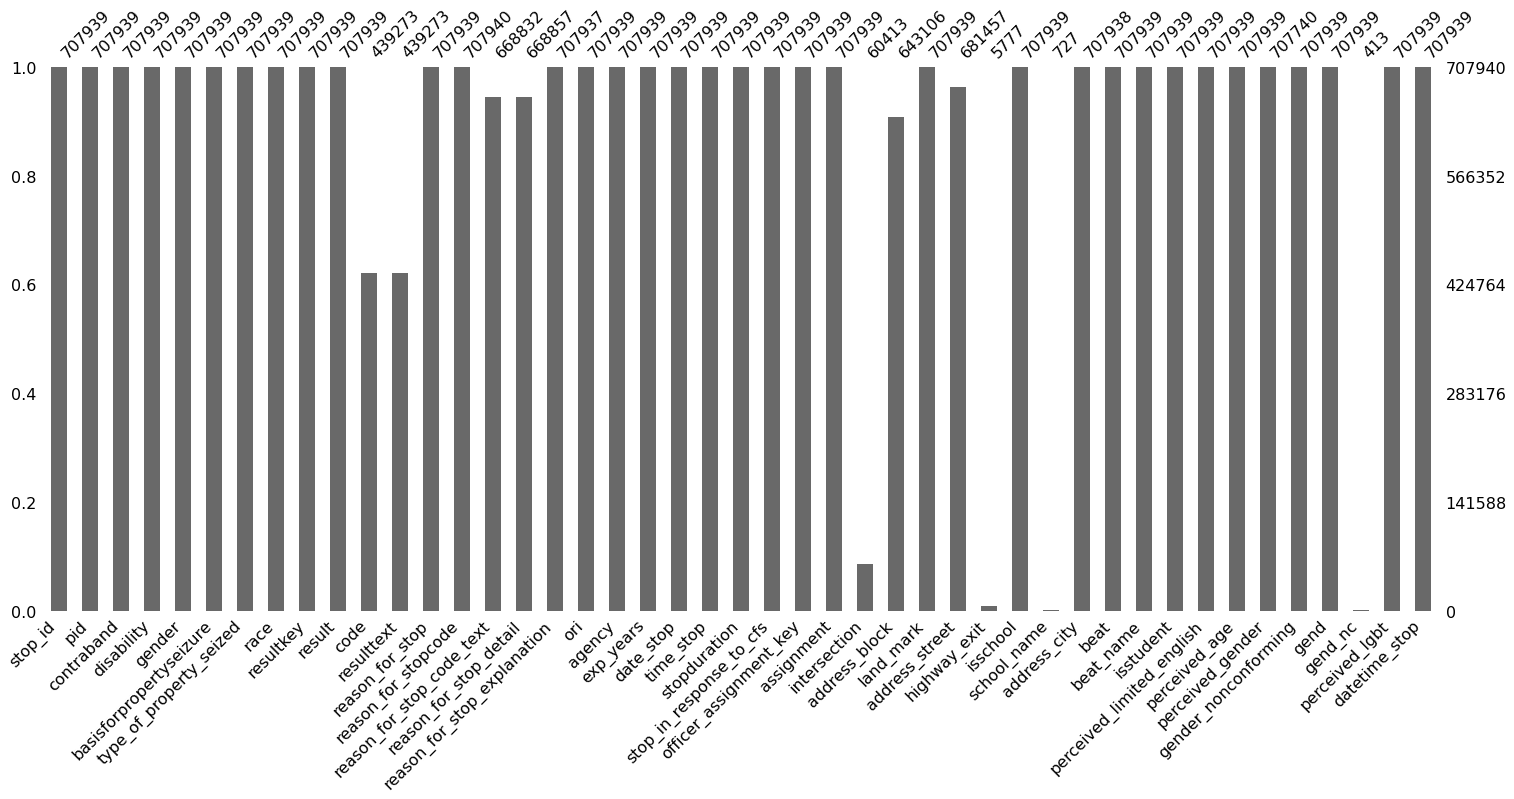

In [4]:
msno.bar(result_df)

In [5]:
#group the stop data by race + calculate proportions + graph
#to visualize the racial breakdown of the stop data overall

In [6]:
stops_racial_breakdown_df = race_df.groupby('race', as_index=False).size()
stops_racial_breakdown_df['proportion'] = stops_racial_breakdown_df['size']/stops_racial_breakdown_df['size'].sum()
stops_racial_breakdown_df

,race,size,proportion
0,Asian,26395,0.049317
1,Black/African American,106550,0.199079
2,Hispanic/Latino/a,157631,0.294519
3,Middle Eastern or South Asian,14948,0.027929
4,Native American,1358,0.002537
5,Pacific Islander,4809,0.008985
6,White,223524,0.417634


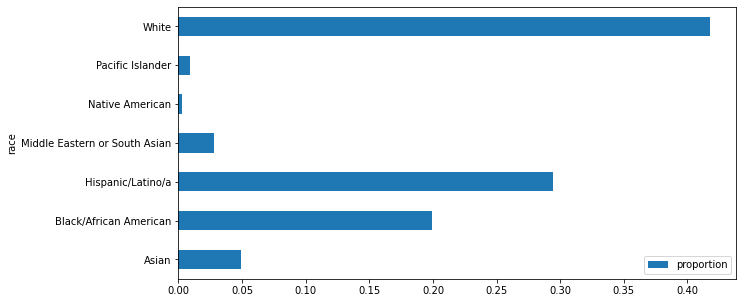

In [7]:
plt.rcParams['figure.figsize'] = (10, 5)
stops_racial_breakdown_df.plot.barh(x="race", y=["proportion"])
plt.show()

In [8]:
#group stop data by the reason for the stop to calculate + visualize proportions (each reason vs stops overall)

In [9]:
stop_by_reason_df = stop_reason_df.groupby(['reason_for_stop'], as_index=False).size()
stop_by_reason_df['proportion'] = stop_by_reason_df['size']/stop_by_reason_df['size'].sum()
stop_by_reason_df

,reason_for_stop,size,proportion
0,Consensual Encounter resulting in a search,6705,0.012281
1,Determine whether the student violated school ...,30,0.000055
2,Investigation to determine whether the person ...,7553,0.013835
3,Knowledge of outstanding arrest warrant/wanted...,5325,0.009754
4,Known to be on Parole / Probation / PRCS / Man...,6793,0.012443
5,Possible conduct warranting discipline under E...,7,0.000013
6,Reasonable Suspicion,287895,0.527332
7,Traffic Violation,231638,0.424287


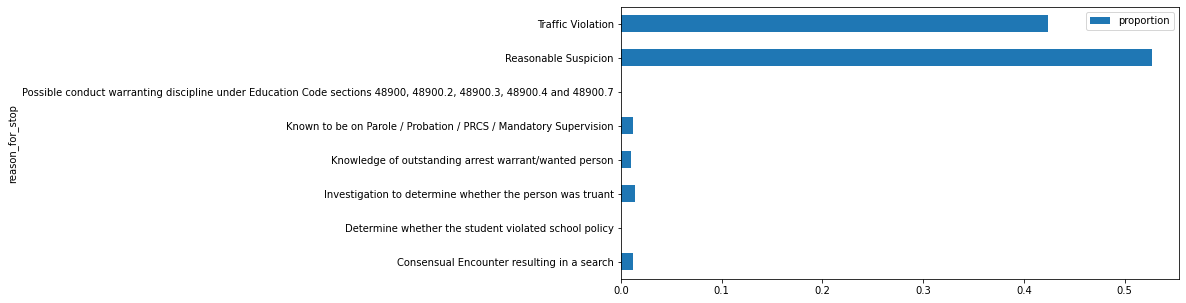

In [10]:
stop_by_reason_df.plot.barh(x="reason_for_stop", y=["proportion"])
plt.show()

In [11]:
#calculate the racial breakdown (amount & proportion) per each reason for the stop 

In [12]:
reason_racial_breakdown_df = pd.merge(race_df, stop_reason_df, how="outer", on=["stop_id","pid"])
reason_racial_breakdown_df = reason_racial_breakdown_df.groupby(['reason_for_stop', 'race'], as_index=False).size()

In [13]:
c_ent = reason_racial_breakdown_df.loc[reason_racial_breakdown_df['reason_for_stop'] == 
                                       'Consensual Encounter resulting in a search' , 'size'].sum()
student = reason_racial_breakdown_df.loc[reason_racial_breakdown_df['reason_for_stop'] == 
                                       'Determine whether the student violated school policy' , 'size'].sum()
truant = reason_racial_breakdown_df.loc[reason_racial_breakdown_df['reason_for_stop'] == 
                                       'Investigation to determine whether the person was truant' , 'size'].sum()
warrant = reason_racial_breakdown_df.loc[reason_racial_breakdown_df['reason_for_stop'] == 
                                       'Knowledge of outstanding arrest warrant/wanted person' , 'size'].sum()
parole = reason_racial_breakdown_df.loc[reason_racial_breakdown_df['reason_for_stop'] == 
                                       'Known to be on Parole / Probation / PRCS / Mandatory Supervision' , 'size'].sum()
conduct = reason_racial_breakdown_df.loc[reason_racial_breakdown_df['reason_for_stop'] == 
                                       'Possible conduct warranting discipline under Education Code sections 48900, 48900.2, 48900.3, 48900.4 and 48900.7' , 'size'].sum()
suspicion = reason_racial_breakdown_df.loc[reason_racial_breakdown_df['reason_for_stop'] == 
                                       'Reasonable Suspicion' , 'size'].sum()
traffic = reason_racial_breakdown_df.loc[reason_racial_breakdown_df['reason_for_stop'] == 
                                       'Traffic Violation' , 'size'].sum()

In [14]:
reason_racial_breakdown_df.loc[reason_racial_breakdown_df.reason_for_stop == 
                              "Consensual Encounter resulting in a search", "total per reason"] = c_ent
reason_racial_breakdown_df.loc[reason_racial_breakdown_df.reason_for_stop == 
                              "Determine whether the student violated school policy", "total per reason"] = student
reason_racial_breakdown_df.loc[reason_racial_breakdown_df.reason_for_stop == 
                              "Investigation to determine whether the person was truant", "total per reason"] = truant
reason_racial_breakdown_df.loc[reason_racial_breakdown_df.reason_for_stop == 
                              "Knowledge of outstanding arrest warrant/wanted person", "total per reason"] = warrant
reason_racial_breakdown_df.loc[reason_racial_breakdown_df.reason_for_stop == 
                              "Known to be on Parole / Probation / PRCS / Mandatory Supervision", "total per reason"] = parole
reason_racial_breakdown_df.loc[reason_racial_breakdown_df.reason_for_stop == 
                              "Possible conduct warranting discipline under Education Code sections 48900, 48900.2, 48900.3, 48900.4 and 48900.7", "total per reason"] = conduct
reason_racial_breakdown_df.loc[reason_racial_breakdown_df.reason_for_stop == 
                              "Reasonable Suspicion", "total per reason"] = suspicion
reason_racial_breakdown_df.loc[reason_racial_breakdown_df.reason_for_stop == 
                              "Traffic Violation", "total per reason"] = traffic

In [15]:
reason_racial_breakdown_df['racial proportion per reason'] = reason_racial_breakdown_df['size']/reason_racial_breakdown_df['total per reason']
reason_racial_breakdown_df.head(7)

,reason_for_stop,race,size,total per reason,racial proportion per reason
0,Consensual Encounter resulting in a search,Asian,252,6774.0,0.037201
1,Consensual Encounter resulting in a search,Black/African American,1317,6774.0,0.194420
2,Consensual Encounter resulting in a search,Hispanic/Latino/a,2231,6774.0,0.329348
3,Consensual Encounter resulting in a search,Middle Eastern or South Asian,89,6774.0,0.013138
4,Consensual Encounter resulting in a search,Native American,30,6774.0,0.004429
5,Consensual Encounter resulting in a search,Pacific Islander,78,6774.0,0.011515
6,Consensual Encounter resulting in a search,White,2777,6774.0,0.409950


In [16]:
#pivot the racial breadown by reason data so that it's easier to visualize 
#visualize in stacked bar chart form

In [17]:
pivoted_df = reason_racial_breakdown_df.pivot(index='reason_for_stop', columns='race', values='size')
pivoted_df

race,Asian,Black/African American,Hispanic/Latino/a,Middle Eastern or South Asian,Native American,Pacific Islander,White
reason_for_stop,,,,,,,
Consensual Encounter resulting in a search,252.0,1317.0,2231.0,89.0,30.0,78.0,2777.0
Determine whether the student violated school policy,1.0,4.0,13.0,2.0,NaN,NaN,11.0
Investigation to determine whether the person was truant,346.0,1770.0,2008.0,139.0,27.0,76.0,3241.0
Knowledge of outstanding arrest warrant/wanted person,208.0,1486.0,1619.0,56.0,21.0,53.0,1936.0
Known to be on Parole / Probation / PRCS / Mandatory Supervision,195.0,1757.0,2355.0,58.0,21.0,58.0,2411.0
"Possible conduct warranting discipline under Education Code sections 48900, 48900.2, 48900.3, 48900.4 and 48900.7",1.0,NaN,3.0,NaN,NaN,NaN,3.0
Reasonable Suspicion,8518.0,65941.0,73873.0,4577.0,980.0,2351.0,134456.0
Traffic Violation,17408.0,38162.0,79947.0,10326.0,339.0,2354.0,86002.0


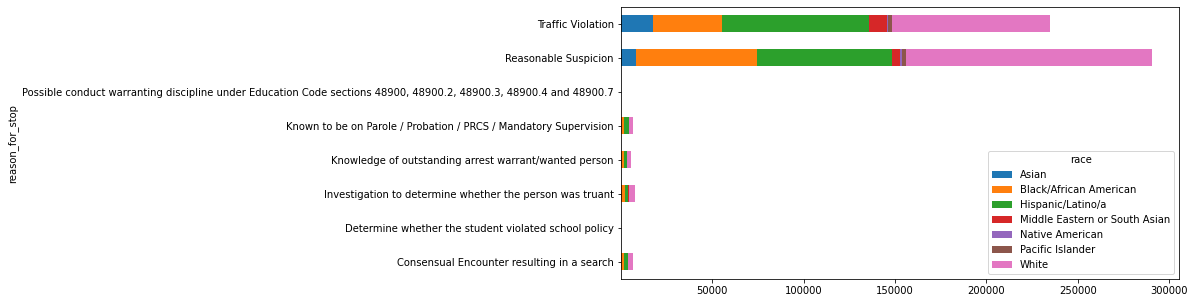

In [18]:
pivoted_df.plot.barh(stacked=True)
plt.show()

In [19]:
#group data by reason and then result + calculate racial breakdown for each reason/result combination

In [20]:
stop_data_df = pd.merge(race_df, stop_reason_df, how="outer", on=["stop_id","pid"])
stop_data_df = pd.merge(stop_data_df, stop_result_df, how="outer", on=["stop_id","pid"])
result_racial_breakdown_df = stop_data_df.groupby(['reason_for_stop','result', 'race'], as_index=False).size()
result_racial_breakdown_df

,reason_for_stop,result,race,size
0,Consensual Encounter resulting in a search,Citation for infraction,Asian,7
1,Consensual Encounter resulting in a search,Citation for infraction,Black/African American,32
2,Consensual Encounter resulting in a search,Citation for infraction,Hispanic/Latino/a,80
3,Consensual Encounter resulting in a search,Citation for infraction,Middle Eastern or South Asian,8
4,Consensual Encounter resulting in a search,Citation for infraction,Native American,2
...,...,...,...,...
443,Traffic Violation,Warning (verbal or written),Hispanic/Latino/a,23522
444,Traffic Violation,Warning (verbal or written),Middle Eastern or South Asian,3156
445,Traffic Violation,Warning (verbal or written),Native American,121
446,Traffic Violation,Warning (verbal or written),Pacific Islander,787


In [21]:
#pivot the racial breakdown by reason/result data so that it's easier to visualize 
#visualize in stacked bar chart form

In [22]:
pivoted_with_reason_result_df = result_racial_breakdown_df.pivot(index=["reason_for_stop", "result"], columns=["race"],values="size")
pivoted_with_reason_result_df = pivoted_with_reason_result_df.div(pivoted_with_reason_result_df.sum(axis=1), axis=0)
pivoted_with_reason_result_df

race                                                                                              Asian  \
reason_for_stop                            result                                                         
Consensual Encounter resulting in a search Citation for infraction                             0.031390   
                                           Contacted parent/legal guardian or other person...  0.032258   
                                           Custodial Arrest pursuant to outstanding warrant    0.027732   
                                           Custodial Arrest without warrant                    0.023766   
                                           Field interview card completed                      0.032003   
...                                                                                                 ...   
Traffic Violation                          In-field cite and release                           0.062540   
                                           No Action                                           0.059211   
                                           Noncriminal transport or caretaking transport       0.041420   
                                           Psychiatric hold                                    0.088710   
                                           Warning (verbal or written)                         0.074127   

race                                                                                           Black/African American  \
reason_for_stop                            result                                                                       
Consensual Encounter resulting in a search Citation for infraction                                           0.143498   
                                           Contacted parent/legal guardian or other person...                0.225806   
                                           Custodial Arrest pursuant to outstanding warrant                  0.176183   
                                           Custodial Arrest without warrant                                  0.212066   
                                           Field interview card completed                                    0.195345   
...                                                                                                               ...   
Traffic Violation                          In-field cite and release                                         0.130013   
                                           No Action                                                         0.223636   
                                           Noncriminal transport or caretaking transport                     0.165680   
                                           Psychiatric hold                                                  0.201613   
                                           Warning (verbal or written)                                       0.185844   

race                                                                                           Hispanic/Latino/a  \
reason_for_stop                            result                                                                  
Consensual Encounter resulting in a search Citation for infraction                                      0.358744   
                                           Contacted parent/legal guardian or other person...           0.483871   
                                           Custodial Arrest pursuant to outstanding warrant             0.337684   
                                           Custodial Arrest without warrant                             0.292505   
                                           Field interview card completed                               0.364505   
...                                                                                                          ...   
Traffic Violation                          In-field cite and release                                    0.

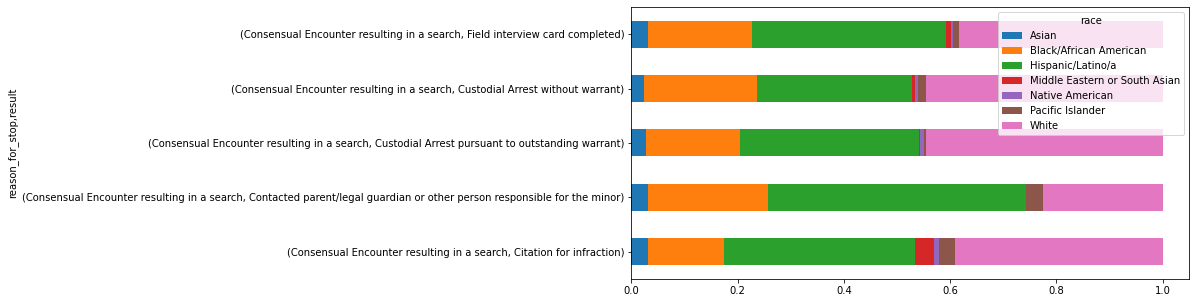

In [23]:
pivoted_with_reason_result_head_df = pivoted_with_reason_result_df.head(5)
pivoted_with_reason_result_head_df.plot.barh(stacked=True)
plt.show()

In [24]:
#using seaborn to graph the racial breakdowns of the four most common stop results
#first together, then individually

<AxesSubplot:xlabel='Density', ylabel='race'>

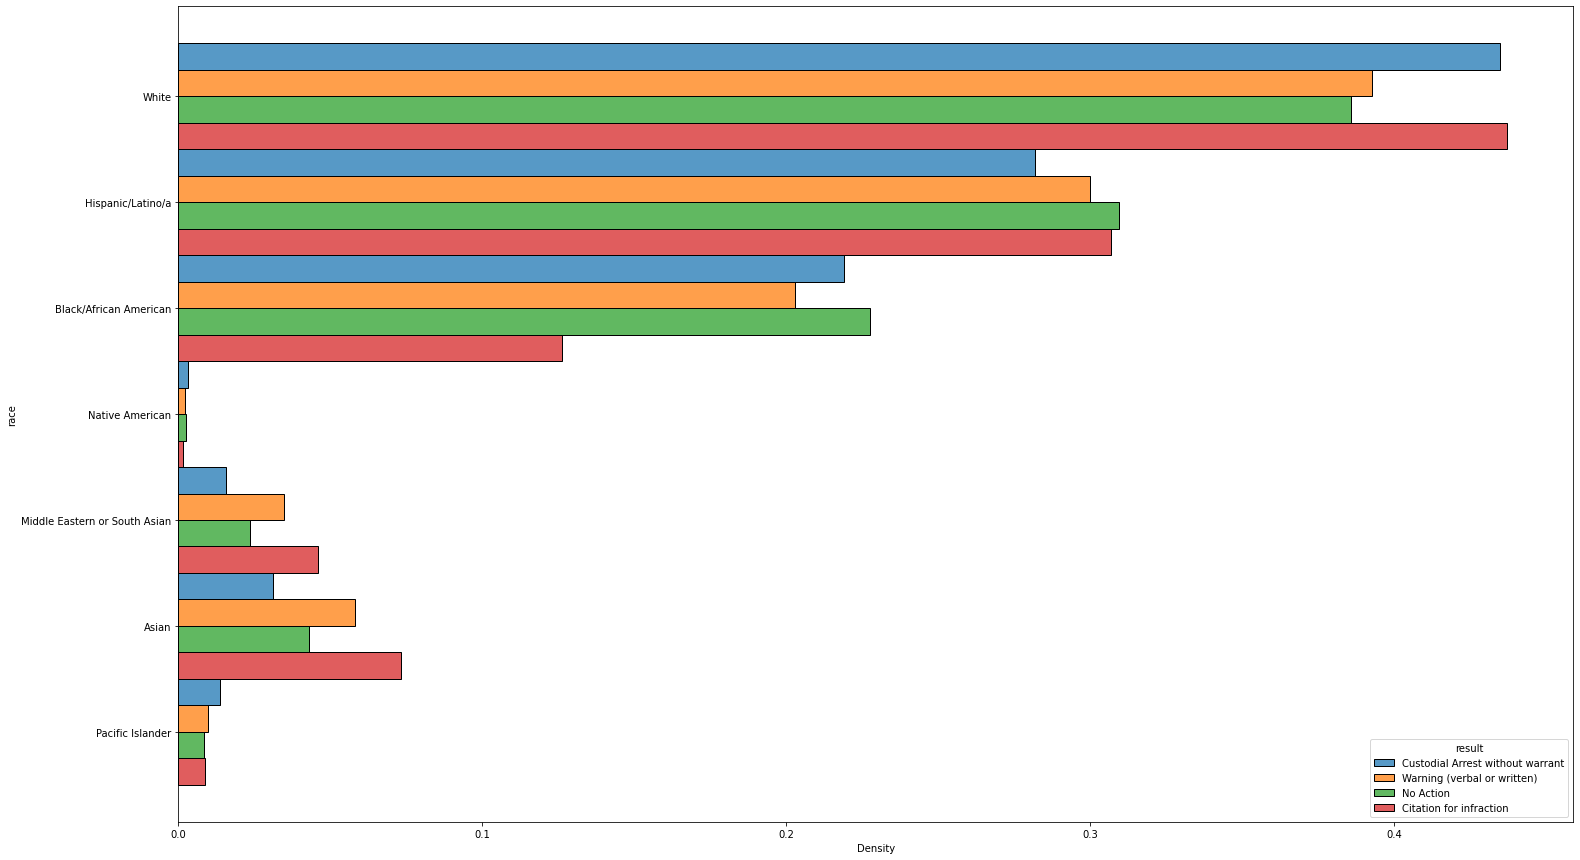

In [25]:
plt.rcParams['figure.figsize'] = (25, 15)
sns.histplot(data=result_df[result_df['result'].isin(['Citation for infraction', 'Custodial Arrest without warrant', 'Warning (verbal or written)', 'No Action'])], y='race', hue='result', stat='density', multiple='dodge', common_norm=False)

<AxesSubplot:xlabel='Density', ylabel='race'>

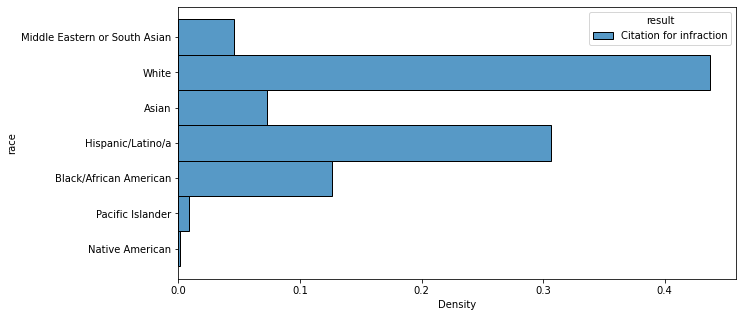

In [26]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.histplot(data=result_df[result_df['result'].isin(['Citation for infraction'])], y='race', hue='result', stat='density', multiple='dodge', common_norm=False)

<AxesSubplot:xlabel='Density', ylabel='race'>

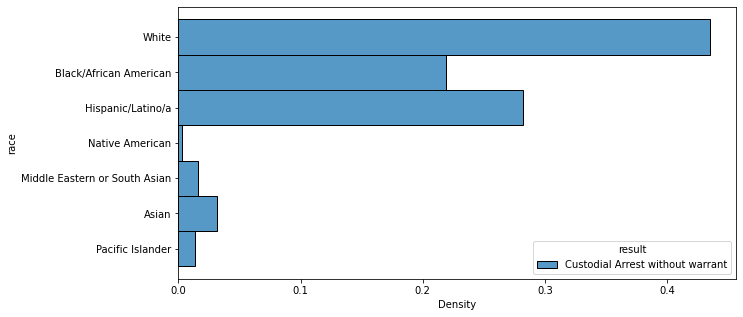

In [27]:
sns.histplot(data=result_df[result_df['result'].isin(['Custodial Arrest without warrant'])], y='race', hue='result', stat='density', multiple='dodge', common_norm=False)

<AxesSubplot:xlabel='Density', ylabel='race'>

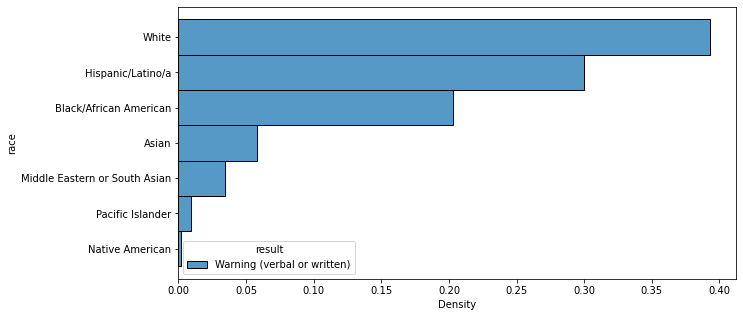

In [28]:
sns.histplot(data=result_df[result_df['result'].isin(['Warning (verbal or written)'])], y='race', hue='result', stat='density', multiple='dodge', common_norm=False)

<AxesSubplot:xlabel='Density', ylabel='race'>

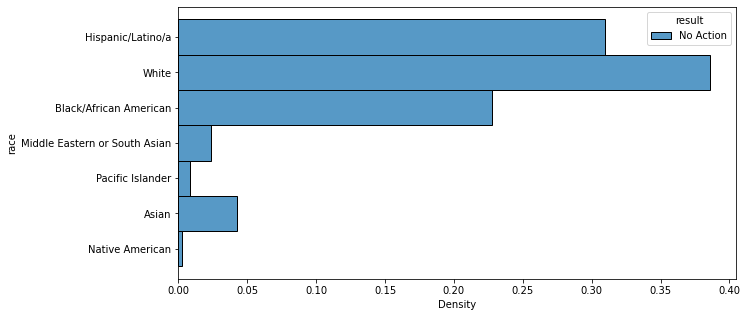

In [29]:
sns.histplot(data=result_df[result_df['result'].isin(['No Action'])], y='race', hue='result', stat='density', multiple='dodge', common_norm=False)

### PART 2: VEIL OF DARKNESS TEST(S)

In [30]:
#creating a separate df that includes only the unique identifying features (stop id, PID)
#and the time of each stop (converted to datetime format)

In [31]:
stop_details_df['datetime_stop'] = pd.to_datetime(stop_details_df['date_stop'] + ' ' + stop_details_df['time_stop'])
VOD_df = stop_details_df[['stop_id', 'pid', 'datetime_stop']]
VOD_df = pd.merge(race_df,VOD_df, how="outer", on=["stop_id","pid"])

In [32]:
#creating functions (& corresponding columns)
#that calculate sunrise, sunset, dusk, & dawn times in SD on the day of each stop
#dusk/dawn times are used to calculate whether the stop occurred during the day (ie between dawn/dusk)

In [33]:
from datetime import time
def dateToSunrise(dt):
    if (type(dt) == float):
        return dt #need to fix this
    d = dt.date()
    s = sun(city.observer, date=d, tzinfo=city.timezone)
    return s['sunrise']

def dateToSunset(dt):
    if (type(dt) == float):
        return dt #need to fix this
    d = dt.date()
    s = sun(city.observer, date=d, tzinfo=city.timezone)
    return s['sunset']
    
VOD_df['sunrise'] = VOD_df['datetime_stop'].map(dateToSunrise)
VOD_df['sunset'] = VOD_df['datetime_stop'].map(dateToSunset)

In [34]:
def dateToDawn(dt):
    if (type(dt) == float):
        return dt #need to fix this
    d = dt.date()
    s = sun(city.observer, date=d, tzinfo=city.timezone)
    return s['dawn']

def dateToDusk(dt):
    if (type(dt) == float):
        return dt #need to fix this
    d = dt.date()
    s = sun(city.observer, date=d, tzinfo=city.timezone)
    return s['dusk']
         
def isDaytime(dt):
    if (type(dt) == float):
       return  False # need to fix this 
    if dt.time() > dateToDawn(dt).time() and dt.time() < dateToDusk(dt).time():
        return True
    else:
        return False
    
def isDaytimeFudged(dt):
    if (type(dt) == float):
       return  False # need to fix this 
    dawnFudged =  dateToDawn(dt) + pd.DateOffset(hours=1)
    duskFudged =  dateToDusk(dt) - pd.DateOffset(hours=1)
    if dt.time() > dawnFudged.time() and dt.time() < duskFudged.time():
        return True
    else:
        return False
    
VOD_df['dawn'] = VOD_df['datetime_stop'].map(dateToSunrise)
VOD_df['dusk'] = VOD_df['datetime_stop'].map(dateToSunset)
VOD_df['is_daytime'] = VOD_df['datetime_stop'].map(isDaytime)
VOD_df['is_daytime_fudged'] = VOD_df['datetime_stop'].map(isDaytimeFudged)

In [35]:
earliestDawn = pd.to_datetime('05:11', format = '%H:%M')
latestDawn = pd.to_datetime('06:42', format = '%H:%M')
earliestDusk = pd.to_datetime('17:09', format = '%H:%M')
latestDusk = pd.to_datetime('20:29', format = '%H:%M')

def withinPeriods(dt):
    if (type(dt) == float):
       return  False # need to fix this 
    if dt.time() > earliestDawn.time() and dt.time() < latestDawn.time():
        return False
    elif dt.time() > earliestDusk.time() and dt.time() < latestDusk.time():
        return False
    else:
        return True
    
VOD_df['original_VOD'] = VOD_df['datetime_stop'].map(withinPeriods)


In [36]:
VOD_df

,stop_id,pid,race,datetime_stop,sunrise,sunset,dawn,dusk,is_daytime,is_daytime_fudged,original_VOD
0,2443,1,White,2018-07-01 00:01:37,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,False,False,True
1,2444,1,White,2018-07-01 00:03:34,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,False,False,True
2,2447,1,Hispanic/Latino/a,2018-07-01 00:05:43,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,False,False,True
3,2447,2,Hispanic/Latino/a,2018-07-01 00:05:43,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,False,False,True
4,2448,1,White,2018-07-01 00:19:06,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,2018-07-01 05:44:42.442709-07:00,2018-07-01 20:00:13.737456-07:00,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
535234,478837,2,Hispanic/Latino/a,2021-09-30 17:39:00,2021-09-30 06:42:31.069332-07:00,2021-09-30 18:33:50.427246-07:00,2021-09-30 06:42:31.069332-07:00,2021-09-30 18:33:50.427246-07:00,True,True,False
535235,478845,1,White,2021-09-30 21:00:00,2021-09-30 06:42:31.069332-07:00,2021-09-30 18:33:50.427246-07:00,2021-09-30 06:42:31.069332-07:00,2021-09-30 18:33:50.427246-07:00,False,False,True
535236,478867,1,White,2021-09-30 15:50:00,2021-09-30 06:42:31.069332-07:00,2021-09-30 18:33:50.427246-07:00,2021-09-30 06:42:31.069332-07:00,2021-09-30 18:33:50.427246-07:00,True,True,True
535237,478867,2,White,2021-09-30 15:50:00,2021-09-30 06:42:31.069332-07:00,2021-09-30 18:33:50.427246-07:00,2021-09-30 06:42:31.069332-07:00,2021-09-30 18:33:50.427246-07:00,True,True,True


In [37]:
#group all stops by whether they take place during day or night. 

<AxesSubplot:xlabel='Density', ylabel='race'>

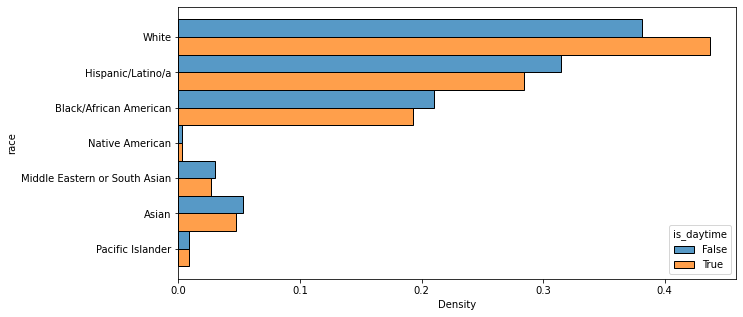

In [38]:
sns.histplot(data=VOD_df, y='race', hue='is_daytime', stat='density', multiple='dodge', common_norm=False)

In [39]:
#fudge the values used to calculate whether or not a stop occurred during the day
#by an hour on each end
#to check for any discrepancies or changes when it comes to the early morning or the beginning of night

<AxesSubplot:xlabel='Density', ylabel='race'>

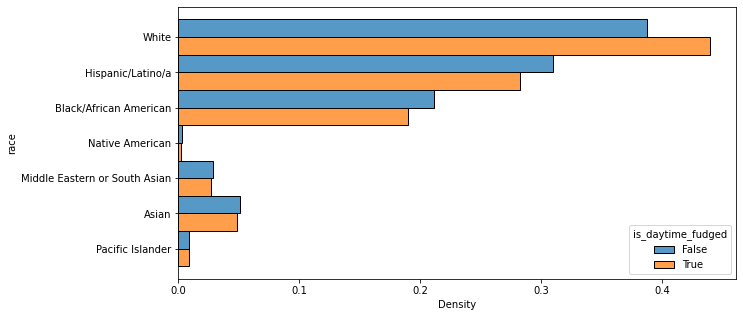

In [40]:
sns.histplot(data=VOD_df, y='race', hue='is_daytime_fudged', stat='density', multiple='dodge', common_norm=False)

In [41]:
#the original VOD test involves removing ambiguity about dusk or dawn
#by counting any stops that occurred between the earliest & latest dusk or dawn times
#as night rather than day
#the two graphs below are visualizations of the breakdown of stops that occurred 
#during the 'day' and during the 'night' (incl. dusk and dawn times)

<AxesSubplot:xlabel='Density', ylabel='race'>

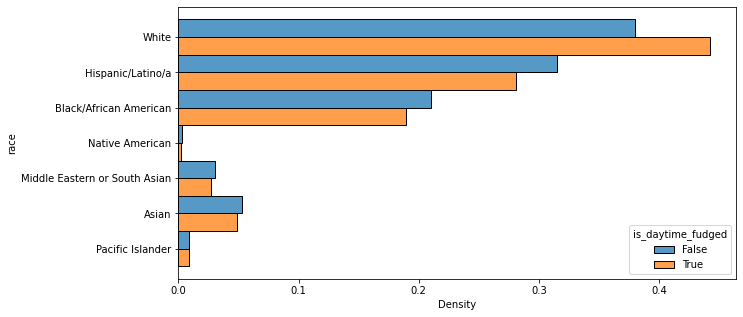

In [42]:
original_VOD_df = VOD_df[VOD_df['original_VOD'] == True]
sns.histplot(data=original_VOD_df, y='race', hue='is_daytime_fudged', stat='density', multiple='dodge', common_norm=False)

<AxesSubplot:xlabel='Density', ylabel='race'>

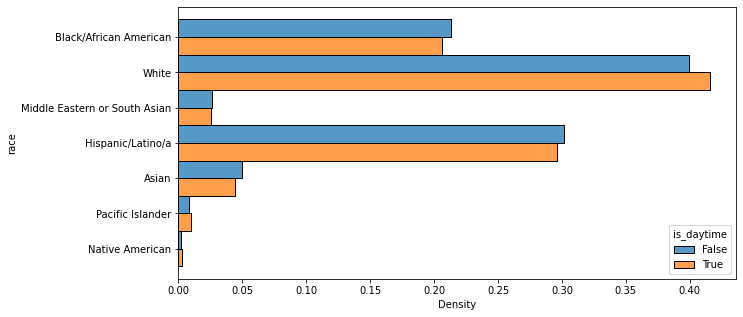

In [43]:
original_VOD_df_2 = VOD_df[VOD_df['original_VOD'] == False] 
sns.histplot(data=original_VOD_df_2, y='race', hue='is_daytime', stat='density', multiple='dodge', common_norm=False)

### PART 3: MULTIPLE CHARGES

In [44]:
#creating a df of only stop id/pid combinations that have more than one charge (ie, stop result) attached to them

In [45]:
unique_stop_df = stop_data_df.groupby(['stop_id','pid'], as_index=False).size() 
multiple_charges_df = unique_stop_df[unique_stop_df['size'] > 1]
multiple_charges_df

,stop_id,pid,size
7,2453.0,1.0,2
15,2462.0,1.0,2
40,2490.0,1.0,2
50,2505.0,1.0,2
53,2508.0,1.0,2
...,...,...,...
529550,478621.0,1.0,4
529554,478625.0,1.0,2
529573,478642.0,1.0,2
529578,478651.0,1.0,2


In [46]:
multiple_charges_df['size'].describe()

count    53742.000000
mean         2.291895
std          0.859710
min          2.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         24.000000
Name: size, dtype: float64

In [47]:
multiple_charges_df['size'].value_counts()

2     44763
3      5017
4      2915
6       478
5       294
8       110
7        40
9        38
12       32
10       31
16       10
15        6
18        3
14        2
24        2
20        1
Name: size, dtype: int64

In [48]:
#visualizing the racial breakdown of people with 2-4 (inclusive) charges
#as those are by far the most common 

In [49]:
common_multiple_charges_df = multiple_charges_df[multiple_charges_df['size'] <= 4 ]
temp_df = result_df[['stop_id', 'pid', 'race']]
common_multiple_charges_df = pd.merge(temp_df, common_multiple_charges_df, how="inner", on=["stop_id","pid"])

<AxesSubplot:xlabel='Count', ylabel='size'>

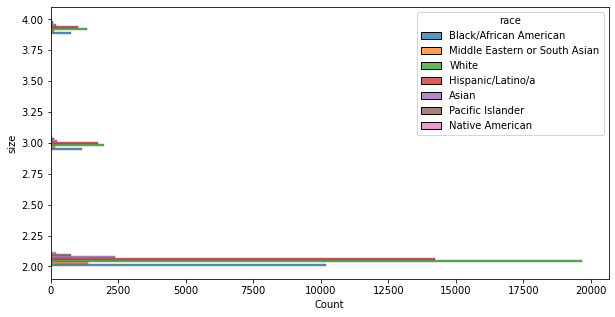

In [50]:
common_multiple_charges_df = common_multiple_charges_df.drop_duplicates()
sns.histplot(data=common_multiple_charges_df, y='size', hue='race', multiple='dodge', common_norm=False)

## Results <a id='results'></a>

First and foremost, breaking down the racial makeup of the overall RIPA stop data revealed that while the majority of racial categories made up approximately the same proportion of the stop data as they did the overall population of San Diego, the Black/African American community was vastly overrepresented. African Americans, who only account for 6.4% of the population of the city of San Diego, made up almost 20% of the RIPA stop data.

The most common reasons for an individual being stopped were “Reasonable Suspicion” and “Traffic Violation” by far.
The vast majority of people stopped for either of these reasons were white, followed by Hispanic/Latinx and then Black/African American. 
Hispanic/Latinx individuals made up around 25.7% and 34.5%, respectively, of stops for “Reasonable Suspicion” and “Traffic Violation,” while Black/African American individuals made up around 22.9% and 16.5% of the same. 

All of these percentages are similar enough to the overall percentages of Hispanic/Latinx and Black/African American people stopped — around 29.5% and 19.9%, respectively, which don’t differ significantly from the percentages of people in these demographics stopped for the two most common reasons. This exploration is therefore inconclusive, as there’s no visible statistical evidence to prove that a disproportionate number of Hispanic/Latinx or Black/African Americans were stopped due to racial bias.

Visualization of the racial breakdown of each possible combination of the reason for the stop and the result of the stop showed similar results. The vast majority of people whose stops involved each reason/result combination were white, followed again by Hispanic/Latinx, followed again by Black/African American, and none of the corresponding percentages were different enough from the overall stop racial percentages to indicate any provable bias. The exceptions in this case were those combinations whose numbers were so small as to be statistically insignificant entirely.

Similarly, when the racial breakdowns of the four most common results of a traffic stop (“Custodial Arrest without warrant,” “Warning (verbal or written),” “No Action,” and “Citation for infraction”) were calculated and graphed, the findings were the same: white majority, followed by Hispanic/Latinx and then Black/African American, with no statistical evidence of racial bias.

The data was also put through the Veil of Darkness test, which involves separating the hours of a given day into categories based on whether they are or are not between dawn and dusk. The logic of the VOD test is that racial bias during police stops (if it exists, that is) should be exaggerated during the daytime because it’s objectively harder for a police officer to identify the race of someone in a car in the dark. Three variations of the test were performed, with one splitting a day into daytime and night as explained above (i.e., between dawn and dusk or not) and the second doing the same except with an hour added to dawn and subtracted from dusk to account for Daylight Savings time. The third dissected the data further by separating out any stops that occurred in the periods between the earliest and latest dawns of the year and the earliest and latest dusks of the year, to avoid any possible ambiguity about when the environment might have been dark. 

For every single test variation, though, every racial category other than White had more instances of stops at night than stops during the daytime, which is the exact opposite result than would be expected for proof of racial bias.

The final exploratory step taken involved the racial breakdown of stops that resulted in multiple charges, as (according to lawyer Coleen Cusack) it’s not unheard of for officers to use “stacked charges” as a punitive measure — pressing charges above a certain number mandates an appearance in court, something many defendants have trouble affording to do. 

However, the results of this were roughly the same as those of the very first set of data explorations: white people were the majority of instances of stacked charges, and the demographics with the next-highest numbers (Hispanic/Latinx and Black/African American, again) didn’t appear in proportions that were significantly different from the percentages of their demographic appearing in the stops overall.


## Discussion <a id='discussion'></a>

The one key aspect of this project that statistically pointed towards bias was the original racial breakdown of the entire collection of stops; as previously mentioned, the African American community was overwhelmingly overrepresented in police stop data when compared to the actual demographics of the city of San Diego. Every other test, however, resulted in a key lack of provable statistical evidence of bias, so this project cannot properly conclude that there was any bias affecting the outcomes of police stops and the resultant charges. 

That said, the results of this project are not necessarily generalizable to the entire court system or even to the entire county. The data measured here is San Diego city data, which isn’t representative of the state as a whole or even of San Diego County. It’s also data specific to traffic stops, which are far from the only source of entry into the criminal justice system. Even if any proof of bias was found, it wouldn’t necessarily hold up in a court of law due to the fact that the text of the CRJA requires statistical proof of racial discrimination on a county-wide scale.
Ultimately, rather than being a sweeping examination of police data and bias in criminal justice across the state of California as a whole, this project was more of an introductory exploration to see if there’s anything on a smaller scale that might also occur on a larger scale before we investigate larger amounts of data. Patiently working through the same forms of exploration with larger, more general datasets could well lead to statistical windfalls.

## Sources + Adjacent Data <a id='sources'></a>

### Sources
* [Full text of the CRJA](https://leginfo.legislature.ca.gov/faces/billTextClient.xhtml?bill_id=201920200AB2542)
* [A less dense breakdown of the bill by the League of Women Voters of California](https://cavotes.org/racial-justice-act-community-implementation)

### Software
* [seaborn](https://seaborn.pydata.org/)
* [missingno](https://github.com/ResidentMario/missingno)
* [astral](https://astral.readthedocs.io/en/latest/index.html)

### Adjacent Data
* [The Stanford Open Policing Project](https://openpolicing.stanford.edu/)
* [Police Scorecard](https://policescorecard.org/findings)
* [The Racial Equity Data Hub](https://www.tableau.com/foundation/data-equity)
* [The 2020 RIPA Board Report](https://oag.ca.gov/sites/all/files/agweb/pdfs/ripa/ripa-board-report-2020.pdf)
* [The 2020 RIPA Technical Report](https://oag.ca.gov/sites/all/files/agweb/pdfs/ripa/ripa-tech-report-2020.pdf)
* [The 2020 LA RIPA Report Quick Facts](https://oag.ca.gov/sites/all/files/agweb/pdfs/ripa/ripa-quick-facts-2020.pdf)
* [The SD Union-Tribune's analysis of geographical stop data](https://www.sandiegouniontribune.com/news/watchdog/story/2022-01-16/stopped-by-police-in-san-diego-a-lot-depends-on-where-you-live-drive)